<a href="https://colab.research.google.com/github/csanicola74/CDC-ATSDR-SVI-Match/blob/main/SVI_SUBJECT_MATCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install all of the necessary libraries for running the script

In [17]:
!pip install pandas
!pip install numpy

# Adding in the 3 CSV Files for the Matching
1. Patient Data taken from Stony Brook University Hospital and Johns Hopkins University Hospital
2. Zip code to County crosswalk file provided by the U.S. Office of Policy Development and Research (PD&R) is used to add county names to the addresses. The crosswalk file is available at https://www.huduser.gov/apps/public/uspscrosswalk/home
3. The SVI data is from the Center for Disease Control and Prevention (CDC) and is available at https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html (Year: 2020; Geography: United States; Geography Type: Counties)

In [18]:
import pandas as pd

# Load the three CSV files into dataframes
address_data = pd.read_csv('/content/cleaned_sample_address_data.csv')
zip_county_crosswalk = pd.read_csv('https://raw.githubusercontent.com/csanicola74/CDC-ATSDR-SVI-Match/main/data/ZIP_COUNTY_032023.csv')
svi_data = pd.read_csv('https://raw.githubusercontent.com/csanicola74/CDC-ATSDR-SVI-Match/main/data/SVI_2020_US_county.csv')

# Match the ZIP CODES to County FIPS

In [19]:
# Pivot the ZIP_COUNTY crosswalk to get each ZIP and its corresponding county FIPS in a single row
zip_county_pivot = zip_county_crosswalk.pivot_table(index='ZIP', values='COUNTY', aggfunc=lambda x: list(x)).reset_index()

In [20]:
# Convert the list of COUNTY FIPS to separate columns
max_counties_for_zip = zip_county_pivot['COUNTY'].apply(len).max()
for i in range(max_counties_for_zip):
    zip_county_pivot[f'COUNTY_{i+1}'] = zip_county_pivot['COUNTY'].apply(lambda x: x[i] if i < len(x) else None)
zip_county_pivot = zip_county_pivot.drop(columns=['COUNTY'])

In [21]:
# Merge the address_data with the reshaped zip_county_pivot
merged_data = pd.merge(address_data, zip_county_pivot, left_on='ZIP CODE', right_on='ZIP', how='left')
merged_data = merged_data.drop(columns=['ZIP'])

# Pull the National Overall SVI Score ('RLP_THEMES') for each County FIPS

In [22]:
# Create a dictionary to map STCNTY (county FIPS) to RPL_THEMES
fips_to_rpl = dict(zip(svi_data['STCNTY'], svi_data['RPL_THEMES']))

# For each COUNTY column in the merged dataframe, map the RPL_THEMES value
for i in range(1, max_counties_for_zip + 1):
    merged_data[f'RPL_THEMES_{i}'] = merged_data[f'COUNTY_{i}'].map(fips_to_rpl)

# Save the final merged dataframe to a CSV file
merged_data.to_csv('final_merged_data.csv', index=False)

In [23]:
# Pull the Unique Value Count of the RPL_THEMES columns
merged_data['RPL_THEMES_1'].value_counts()

0.8845    1394
0.9955     876
0.6668     711
0.7747     692
0.5808     116
0.6817       4
Name: RPL_THEMES_1, dtype: int64

In [24]:
merged_data['RPL_THEMES_2'].value_counts()

0.8845    91
0.6817    68
0.2782    26
0.6668    14
0.9955     4
Name: RPL_THEMES_2, dtype: int64

In [25]:
merged_data['RPL_THEMES_3'].value_counts()

Series([], Name: RPL_THEMES_3, dtype: int64)

In [26]:
merged_data['RPL_THEMES_4'].value_counts()

Series([], Name: RPL_THEMES_4, dtype: int64)

In [27]:
merged_data['RPL_THEMES_5'].value_counts()

Series([], Name: RPL_THEMES_5, dtype: int64)

In [28]:
merged_data['RPL_THEMES_6'].value_counts()

Series([], Name: RPL_THEMES_6, dtype: int64)

In [29]:
merged_data['RPL_THEMES_7'].value_counts()

Series([], Name: RPL_THEMES_7, dtype: int64)

In [34]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, mode

# Convert the data to a pandas Series for easier statistical calculations
series = merged_data['RPL_THEMES_1']

# Compute the statistics
count = series.count()
mean = series.mean()
median = series.median()
mode_result = mode(merged_data['RPL_THEMES_1'])
std_dev = series.std()
min_val = series.min()
max_val = series.max()
q25, q50, q75 = series.quantile([0.25, 0.5, 0.75])
skewness = skew(series)
kurt = kurtosis(series)

print(f"Count: {count}")
print(f"Mean: {mean}")
print(f"Median: {median}")
# Check if mode_count is scalar or array/list
if np.isscalar(mode_result.count):
    if mode_result.count > 1:  # Only display mode if it occurs more than once
        print(f"Mode: {mode_result.mode} (occurs {mode_result.count} times)")
    else:
        print("No mode found (all values are unique).")
else:
    print(f"Mode: {mode_result.mode[0]} (occurs {mode_result.count[0]} times)")
print(f"Standard Deviation: {std_dev}")
print(f"Minimum Value: {min_val}")
print(f"Maximum Value: {max_val}")
print(f"25th Percentile: {q25}")
print(f"50th Percentile: {q50}")
print(f"75th Percentile: {q75}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")






Count: 3793
Mean: 0.8397937780121274
Median: 0.8845
Mode: 0.8845 (occurs 1394 times)
Standard Deviation: 0.12164848599043933
Minimum Value: 0.5808
Maximum Value: 0.9955
25th Percentile: 0.7747
50th Percentile: 0.8845
75th Percentile: 0.8845
Skewness: -0.36208634561210795
Kurtosis: -0.9593806559183209


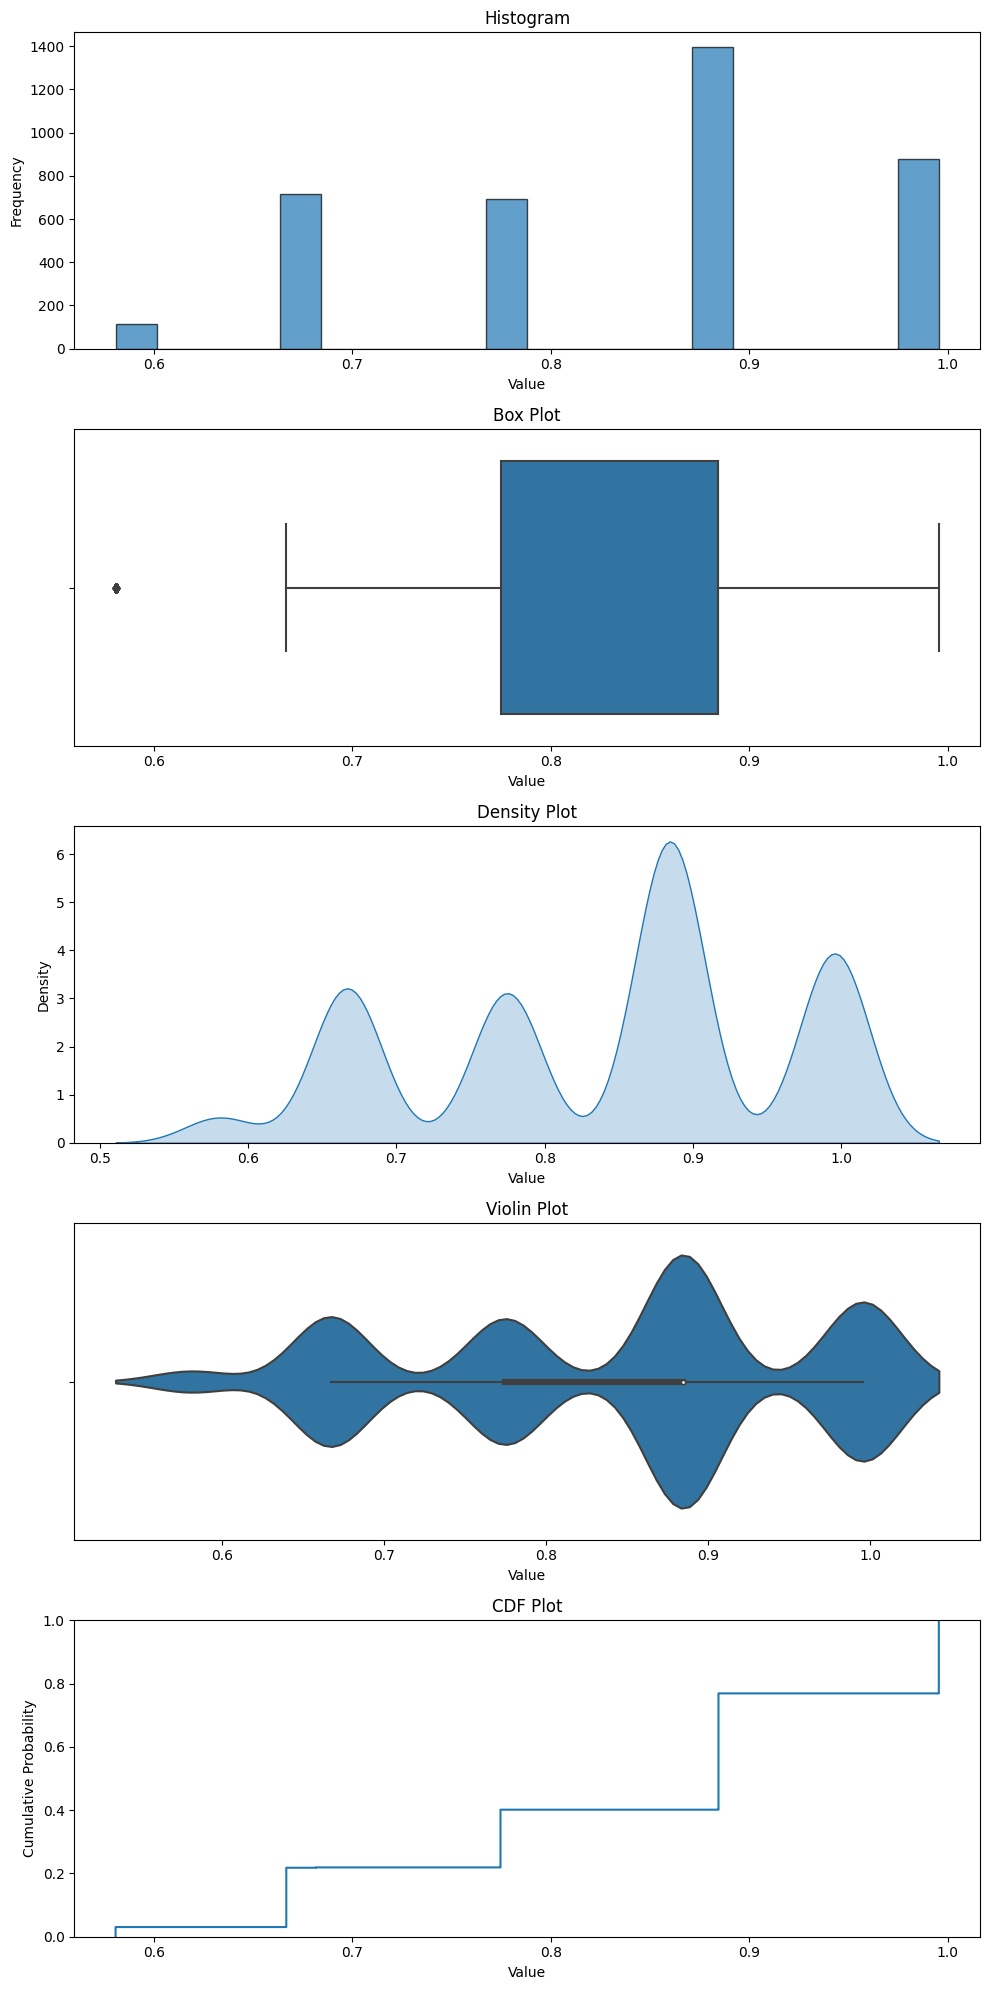

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Histogram
axs[0].hist(series, bins=20, edgecolor='black', alpha=0.7)
axs[0].set_title('Histogram')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Box Plot
sns.boxplot(x=series, ax=axs[1])
axs[1].set_title('Box Plot')
axs[1].set_xlabel('Value')

# Density Plot
sns.kdeplot(series, ax=axs[2], fill=True)
axs[2].set_title('Density Plot')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Density')

# Violin Plot
sns.violinplot(x=series, ax=axs[3])
axs[3].set_title('Violin Plot')
axs[3].set_xlabel('Value')

# CDF Plot
sns.ecdfplot(series, ax=axs[4])
axs[4].set_title('CDF Plot')
axs[4].set_xlabel('Value')
axs[4].set_ylabel('Cumulative Probability')

plt.tight_layout()
plt.show()
